In [1]:
import numpy as np
from matplotlib import pyplot as plt
import GPy
from scipy.stats import multivariate_normal as mvn
import pandas as pd
import yaml
from typing import Dict
import json

from eqsql import worker_pool, db_tools
from eqsql.task_queues import local_queue



In [2]:
def initial_samples(n):
    xx = np.linspace(0, 1, 30)
    Xgrid = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2)

    N = Xgrid.shape[0]
    init_id = np.random.choice(N, n, replace=False)
    return (Xgrid[init_id], Xgrid)

    # color selected points
    # col_vec = np.array(['grey'] * N)
    # col_vec[init_id] = 'red'

    # plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=col_vec, s=40)
    # plt.xlabel('$x_1$')
    # plt.ylabel('$x_2$')
    # plt.title('Initial starting points')
    # plt.show()

In [3]:
# scaling function
def to_native(x, lb, ub):
    x_native = np.empty_like(x)
    for i in range(x.shape[1]): 
        x_native[:, i] = lb[i] + x[:, i] * (ub[i] - lb[i])
    return x_native


def TS_npoints(model, npoints, Xgrid, inflate_factor=2):
        
    #' Batch Bayesian optimization using Thompson sampling
    #'
    #' @param model an object of class `hetGP`; e.g., as returned by `mleHetGP`
    #' @param npoints an integer representing the desired number of samples
    #' @param Xgrid a matrix of locations at which the samples are drawn
    #'
    #' @return a matrix containing the `npoints` best locations where next batch of simulations should be run

    pred_mean, pred_cov = model.predict(Xgrid, full_cov=True)
    cov_mtx = 0.5 * (pred_cov + pred_cov.T)
    tTS = mvn.rvs(mean=pred_mean.reshape(-1), cov=cov_mtx, size=npoints * 2)
    best_ids = list(set(np.argmin(tTS, axis=1)))[:npoints]
    return Xgrid[best_ids]

In [23]:
def run(exp_id: str, params: Dict):

    db_started = False
    pool = None
    task_queue = None

    try:
        # start database
        db_tools.start_db(params['db_path'], pg_bin_path=params['pg_bin_path'])
        db_started = True

        # start local task queue
        task_queue = local_queue.init_task_queue(params['db_host'], params['db_user'],
                                                    port=None, db_name=params['db_name'])

        # check if the input and output queues are empty,
        # if not, then exit with a warning.
        if not task_queue.are_queues_empty():
            print("WARNING: db input / output queues are not empty. Aborting run", flush=True)
            task_queue.clear_queues()
            return

        # start worker pool
        pool_params = worker_pool.cfg_file_to_dict(params['pool_cfg_file'])
        pool = worker_pool.start_local_pool(params['worker_pool_id'], params['pool_launch_script'],
                                            exp_id, pool_params)
        task_type = params['task_type']

        n1 = 10
        X, Xgrid = initial_samples(n1)
        Xnative = to_native(X, lb=np.array([0, 1]), ub=np.array([1, 3]))
        
        payloads = list(map(lambda a: json.dumps(list(a)), Xnative))
        _, fts = task_queue.submit_tasks(exp_id, task_type, payloads)

        sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
        Y = np.array([-json.loads(ft.result()[1]) for ft in sorted_fts])

        # keep track of best 
        f_best = []
        X_best = np.empty((0, 2))

        f_best.append(np.min(Y))
        X_best = np.vstack([X_best, X[np.argmin(Y)]])

        
        native_best = to_native(X_best, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
        print(f">> iter = 0: current best value = {-f_best[0]} at zombie_step_size = {native_best[0, 0]}, human_step_size = {native_best[0, 1]}")

        # fit GP (note: haven't checked how similar implementation is to the HetGP version, so solutions might be different)
        gp = GPy.models.GPRegression(X, Y.reshape(-1,1))
        gp.optimize()

        n_steps = params['n_steps']
        n_points = params['n_points']

        for i in np.arange(1, n_steps + 1):
            X_new = TS_npoints(model = gp, npoints = n_points, Xgrid = Xgrid)
            X_new_native = to_native(X_new, lb= np.array([0.1, 1]), ub=np.array([1, 3]))
            payloads = list(map(lambda a: json.dumps(list(a)), X_new_native))
            _, fts = task_queue.submit_tasks(exp_id, task_type, payloads)
            sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
            Y_new = np.array([-json.loads(ft.result()[1]) for ft in sorted_fts])

            # append to existing best
            X = np.vstack([gp.X, X_new])
            Y = np.vstack([gp.Y, Y_new.reshape(-1,1)])

            # update GP with new data
            #gp.set_XY(X, Y)
            gp = GPy.models.GPRegression(X, Y.reshape(-1,1))
            gp.optimize()

            best_ix = np.argmin(Y)
            f_best.append(Y[best_ix][0])
            X_best = np.vstack([X_best, X[best_ix]])

            native_best = to_native(X_best, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
            print(f">> iter = {i}: current best value = {-f_best[i]} at zombie_step_size = {native_best[i, 0]}, human_step_size = {native_best[i, 1]}")

        # Plot sequential trajectory
        clist = ['red']*n1 + ['navy']*(X.shape[0]-n1)
        alist = [1]*n1 + list(np.linspace(.1, 1, X.shape[0]-n1))
                            
        plt.scatter(X[:,0], X[:,1], alpha=alist, c=clist)
        plt.show()

        return (X, Y)
                    

    finally:
        if task_queue is not None:
            task_queue.close()
        if pool is not None:
            pool.cancel()
        if db_started:
            db_tools.stop_db(params['db_path'])

Checking for pg_ctl ...
/home/nick/miniconda3/envs/emews-py3.10/bin/pg_ctl


Starting database with log:/home/nick/Documents/db/wsc_tutorial/db.log
Database server started
>> iter = 0: current best value = 3751.0 at zombie_step_size = 0.16206896551724137, human_step_size = 1.7586206896551724
>> iter = 1: current best value = 3751.0 at zombie_step_size = 0.16206896551724137, human_step_size = 1.7586206896551724
>> iter = 2: current best value = 3751.0 at zombie_step_size = 0.16206896551724137, human_step_size = 1.7586206896551724
>> iter = 3: current best value = 3770.2 at zombie_step_size = 0.16206896551724137, human_step_size = 1.206896551724138
>> iter = 4: current best value = 3880.6 at zombie_step_size = 0.1, human_step_size = 1.0


 /home/nick/miniconda3/envs/emews-py3.10/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/nick/miniconda3/envs/emews-py3.10/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/nick/miniconda3/envs/emews-py3.10/lib/python3.10/site-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply


>> iter = 5: current best value = 3880.6 at zombie_step_size = 0.1, human_step_size = 1.0
>> iter = 6: current best value = 3880.6 at zombie_step_size = 0.1, human_step_size = 1.0
>> iter = 7: current best value = 3880.6 at zombie_step_size = 0.1, human_step_size = 1.0
>> iter = 8: current best value = 3880.6 at zombie_step_size = 0.1, human_step_size = 1.0
>> iter = 9: current best value = 3880.6 at zombie_step_size = 0.1, human_step_size = 1.0
>> iter = 10: current best value = 3880.6 at zombie_step_size = 0.1, human_step_size = 1.0


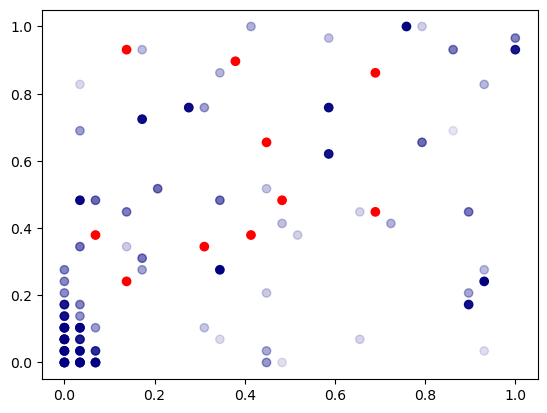

Checking for pg_ctl ...
/home/nick/miniconda3/envs/emews-py3.10/bin/pg_ctl


Stopping database server

waiting for server to shut down.... done
server stopped



In [24]:
from eqsql import cfg
config_file = "./algo_cfg.yaml"
params = cfg.parse_yaml_cfg(config_file)
X, Y = run('t1', params)

In [19]:
X

array([[0.5862069 , 0.62068966],
       [0.93103448, 1.        ],
       [0.44827586, 0.10344828],
       [0.72413793, 0.17241379],
       [0.89655172, 0.20689655],
       [0.37931034, 0.93103448],
       [0.65517241, 0.72413793],
       [0.37931034, 0.34482759],
       [0.34482759, 0.27586207],
       [0.10344828, 0.62068966],
       [0.13793103, 0.55172414],
       [0.13793103, 0.65517241],
       [0.75862069, 0.03448276],
       [0.62068966, 0.        ],
       [0.31034483, 0.79310345],
       [0.93103448, 0.        ],
       [0.17241379, 0.72413793],
       [0.75862069, 0.86206897],
       [0.17241379, 0.89655172],
       [0.93103448, 0.86206897],
       [0.        , 0.72413793],
       [0.17241379, 0.5862069 ],
       [0.75862069, 0.82758621],
       [0.62068966, 0.5862069 ],
       [0.06896552, 0.06896552],
       [0.34482759, 0.72413793],
       [0.51724138, 0.24137931],
       [0.79310345, 0.82758621],
       [0.96551724, 0.24137931],
       [0.20689655, 0.93103448],
       [0.

In [22]:
Y

array([[-3110.6],
       [-2468.6],
       [-3491.4],
       [-3198.4],
       [-3007.2],
       [-3297.6],
       [-2983.8],
       [-3450. ],
       [-3500.8],
       [-3674.8],
       [-3558.2],
       [-3547.4],
       [-3282.4],
       [-3406.4],
       [-3323.6],
       [-3225. ],
       [-3493.2],
       [-2734.6],
       [-3476.6],
       [-2508. ],
       [-3667.2],
       [-3519.4],
       [-2748.6],
       [-3049.6],
       [-3790.6],
       [-3298. ],
       [-3300.8],
       [-2730.8],
       [-2901.4],
       [-3423.4],
       [-3329.8],
       [-2987.8],
       [-3471.8],
       [-3563.4],
       [-3297.4],
       [-3199.4],
       [-3215.2],
       [-3194.4],
       [-3703.8],
       [-3463.2],
       [-2670.4],
       [-3770.2],
       [-3555.6],
       [-3343. ],
       [-3171.6],
       [-3584.6],
       [-3563.4],
       [-3493.2],
       [-2734.6],
       [-3439.4],
       [-3880.6],
       [-3864.6],
       [-3841.6],
       [-3830.8],
       [-3820. ],
       [-3

In [21]:
np.save('/home/nick/X.npy', X)
np.save('/home/nick/Y.npy', Y)